# Reinforcement Learning - Policy Gradient
If you want to test/submit your solution **restart the kernel, run all cells and submit the pg_autograde.py file into codegrade.**

In [1]:
# This cell imports %%execwritefile command (executes cell and writes it into file). 
from custommagics import CustomMagics
get_ipython().register_magics(CustomMagics)

In [2]:
%%execwritefile pg_autograde.py
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm as _tqdm

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

Overwriting pg_autograde.py


In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import sys

import gym
import time

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

---

## 3. Policy Gradient

### 3.1 Policy Network

In order to implement policy gradient, we will first implement a class with a policy network. Although in general this does not have to be the case, we will use an architecture very similar to the Q-network that we used (two layers with ReLU activation for the hidden layer). Since we have discrete actions, our model will output one value per action, where each value represents the (normalized!) probability of selecting that action. *Use the softmax activation function.*

In [31]:
%%execwritefile -a pg_autograde.py

class NNPolicy(nn.Module):
    
    def __init__(self, num_hidden=128):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(4, num_hidden)
        self.l2 = nn.Linear(num_hidden, 2)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()

    def forward(self, x):
        """
        Performs a forward pass through the network.
        
        Args:
            x: input tensor (first dimension is a batch dimension)
            
        Return:
            Probabilities of performing all actions in given input states x. Shape: batch_size x action_space_size
        """
        return self.softmax(self.l2(self.relu(self.l1(x))))
        
    def get_probs(self, obs, actions):
        """
        This function takes a tensor of states and a tensor of actions and returns a tensor that contains 
        a probability of perfoming corresponding action in all states (one for every state action pair). 

        Args:
            obs: a tensor of states. Shape: batch_size x obs_dim
            actions: a tensor of actions. Shape: batch_size x 1

        Returns:
            A torch tensor filled with probabilities. Shape: batch_size x 1.
        """
        pred = self.forward(obs)
        actions = torch.squeeze(actions)

        actions_1 = torch.zeros_like(pred)
        actions_1[:, 0] = (actions - 1) * -1
        actions_1[:, 1] = actions
        
        action_probs = torch.sum(pred * actions_1, dim=1, keepdim=True)
        return action_probs
    
    def sample_action(self, obs):
        """
        This method takes a state as input and returns an action sampled from this policy.  

        Args:
            obs: state as a tensor. Shape: 1 x obs_dim or obs_dim

        Returns:
            An action (int).
        """
        return torch.multinomial(self.forward(obs), 1)

        

Appending to pg_autograde.py


In [32]:
# Let's instantiate and test if it works
num_hidden = 128
torch.manual_seed(1234)
policy = NNPolicy(num_hidden)

states = torch.rand(10, 4)
actions = torch.randint(low=0, high=2, size=(10,1))
print(actions)

# Does the outcome make sense?
forward_probs = policy.forward(states)
print(forward_probs)
assert forward_probs.shape == (10,2), "Output of forward has incorrect shape."
sampled_action = policy.sample_action(states[0])
assert sampled_action == 0 or sampled_action == 1, "Output of sample action is not 0 or 1"

action_probs = policy.get_probs(states, actions)
print(action_probs)
assert action_probs.shape == (10,1), "Output of get_probs has incorrect shape."

tensor([[0],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0],
        [1],
        [0],
        [0]])
tensor([[0.4578, 0.5422],
        [0.4657, 0.5343],
        [0.4563, 0.5437],
        [0.4634, 0.5366],
        [0.4564, 0.5436],
        [0.4725, 0.5275],
        [0.4769, 0.5231],
        [0.4834, 0.5166],
        [0.4797, 0.5203],
        [0.4618, 0.5382]], grad_fn=<SoftmaxBackward>)
tensor([[0.4578],
        [0.5343],
        [0.5437],
        [0.4634],
        [0.4564],
        [0.5275],
        [0.4769],
        [0.5166],
        [0.4797],
        [0.4618]], grad_fn=<SumBackward1>)


### 3.2 Monte Carlo REINFORCE

Now we will implement the *Monte Carlo* policy gradient algorithm. Remember that this means that we will estimate returns for states by sample episodes. Compared to DQN, this means that we do *not* perform an update step at every environment step, but only at the end of each episode. This means that we should generate an episode of data, compute the REINFORCE loss (which requires computing the returns) and then perform a gradient step.

* You can use `torch.multinomial` to sample from a categorical distribution.
* The REINFORCE loss is defined as $- \sum_t \log \pi_\theta(a_t|s_t) G_t$, which means that you should compute the (discounted) return $G_t$ for all $t$. Make sure that you do this in **linear time**, otherwise your algorithm will be very slow! Note the - (minus) since you want to maximize return while you want to minimize the loss.

To help you, we wrote down signatures of a few helper functions. Start by implementing a sampling routine that samples a single episode (similarly to the one in Monte Carlo lab).

In [33]:
%%execwritefile -a pg_autograde.py

def sample_episode(env, policy):
    """
    A sampling routine. Given environment and a policy samples one episode and returns states, actions, rewards
    and dones from environment's step function as tensors.

    Args:
        env: OpenAI gym environment.
        policy: A policy which allows us to sample actions with its sample_action method.

    Returns:
        Tuple of tensors (states, actions, rewards, dones). All tensors should have same first dimension and 
        should have dim=2. This means that vectors of length N (states, rewards, actions) should be Nx1.
        Hint: Do not include the state after termination in states.
    """
    states = []
    actions = []
    rewards = []
    dones = []
    
    obs = env.reset()
    done = False
    while not done:
        obs = torch.Tensor(obs)

        states.append(obs)
        action = policy.sample_action(obs)
        obs, reward, done, _ = env.step(int(action))

        actions.append(action)
        rewards.append(reward)
        dones.append(done)

    states_2t = torch.Tensor(len(states), len(states[0]))
    for i in range(len(states_2t)):
        states_2t[i] = states[i]

    actions_2t = torch.Tensor(len(actions), len(actions[0]))
    torch.cat(actions, out=actions_2t)
    return states_2t, torch.LongTensor(actions), torch.Tensor(rewards), torch.Tensor(dones)

Appending to pg_autograde.py


In [34]:
# Let's sample some episodes
env = gym.envs.make("CartPole-v1")
num_hidden = 128
torch.manual_seed(1234)
policy = NNPolicy(num_hidden)
for episode in range(3):
    trajectory_data = sample_episode(env, policy)

Now implement loss computation and training loop of the algorithm.

In [47]:
%%execwritefile -a pg_autograde.py

def compute_reinforce_loss(policy, episode, discount_factor):
    """
    Computes reinforce loss for given episode.

    Args:
        policy: A policy which allows us to get probabilities of actions in states with its get_probs method.

    Returns:
        loss: reinforce loss
    """
    # Compute the reinforce loss
    states, actions, rewards, _ = episode
    probs = policy.get_probs(states, actions)
    
    g = 0
    G = [discount_factor * g + rewards[t] for t in range(len(states) - 1, -1, -1)]
    G.reverse()
    G = torch.Tensor(G).unsqueeze(0)

    loss = - G @ torch.log(probs)
    return loss


def run_episodes_policy_gradient(policy, env, num_episodes, discount_factor, learn_rate, 
                                 sampling_function=sample_episode):
    optimizer = optim.Adam(policy.parameters(), learn_rate)

    episode_durations = []
    for i in range(num_episodes):

        optimizer.zero_grad()
        episode = sample_episode(env, policy)
        loss = compute_reinforce_loss(policy, episode, discount_factor)
        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print("{2} Episode {0} finished after {1} steps"
                  .format(i, len(episode[0]), '\033[92m' if len(episode[0]) >= 195 else '\033[99m'))
        episode_durations.append(len(episode[0]))
        
    return episode_durations

Appending to pg_autograde.py


In [48]:
# Smoothing function for nicer plots
def smooth(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

 Episode 0 finished after 24 steps
 Episode 10 finished after 16 steps
 Episode 20 finished after 32 steps
 Episode 30 finished after 25 steps
 Episode 40 finished after 8 steps
 Episode 50 finished after 15 steps
 Episode 60 finished after 11 steps
 Episode 70 finished after 18 steps
 Episode 80 finished after 16 steps
 Episode 90 finished after 14 steps
 Episode 100 finished after 9 steps
 Episode 110 finished after 18 steps
 Episode 120 finished after 10 steps
 Episode 130 finished after 11 steps
 Episode 140 finished after 9 steps
 Episode 150 finished after 15 steps
 Episode 160 finished after 10 steps
 Episode 170 finished after 10 steps
 Episode 180 finished after 25 steps
 Episode 190 finished after 28 steps
 Episode 200 finished after 30 steps
 Episode 210 finished after 13 steps
 Episode 220 finished after 22 steps
 Episode 230 finished after 11 steps
 Episode 240 finished after 11 steps
 Episode 250 finished after 10 steps
 Episode 260 finished after 20 steps
 Episode 270 fi

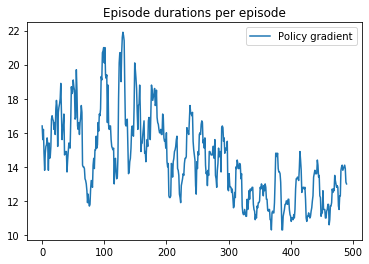

In [50]:
# Feel free to play around with the parameters!
num_episodes = 500
discount_factor = 0.99
learn_rate = 0.001
seed = 42
env = gym.envs.make("CartPole-v1")
torch.manual_seed(seed)
env.seed(seed)
policy = NNPolicy(num_hidden)

episode_durations_policy_gradient = run_episodes_policy_gradient(
    policy, env, num_episodes, discount_factor, learn_rate)

plt.plot(smooth(episode_durations_policy_gradient, 10))
plt.title('Episode durations per episode')
plt.legend(['Policy gradient'])

If you want to test/submit your solution **restart the kernel, run all cells and submit the pg_autograde.py file into codegrade.**